<a href="https://colab.research.google.com/github/IzaakGagnon/SSC_GliderProject/blob/main/GWR_Work.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install mgwr

Dataset preview:
                       time   latitude  longitude      depth  \
999077  2020-08-19 14:15:55  48.082236 -63.227349  10.153757   
812287  2020-08-07 20:15:58  48.194404 -63.863960  32.650524   
998728  2020-08-19 14:04:17  48.082412 -63.226035  32.693822   
696354  2020-08-04 17:54:34  47.992331 -63.985572  40.166200   
972041  2020-08-16 16:00:44  48.350994 -63.317158  12.030266   

        sea_water_temperature  sea_water_practical_salinity  \
999077              19.837550                     28.838122   
812287               1.277100                     31.368080   
998728               1.853300                     30.988988   
696354               1.357600                     31.461066   
972041              10.021687                     29.962308   

        sea_water_density  micromoles_of_oxygen_per_unit_mass_in_sea_water  
999077        1020.161099                                       234.529842  
812287        1025.269055                                       2

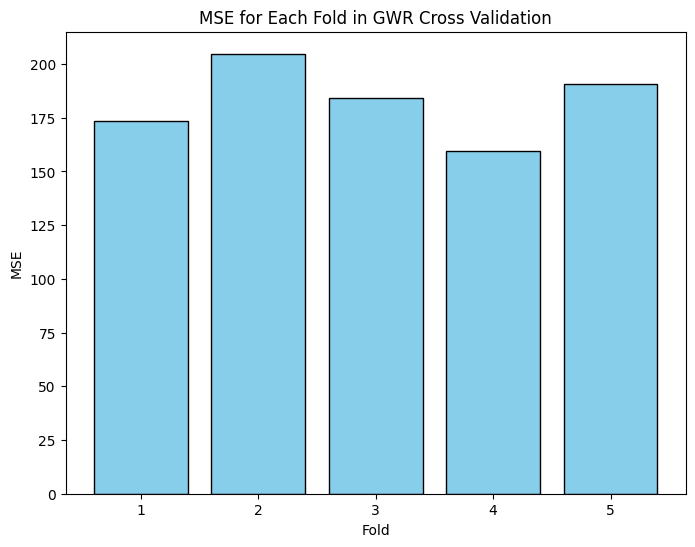


GWR Model Summary:


NotImplementedError: Not available for GWR prediction

In [13]:
import pandas as pd
import numpy as np
from mgwr.gwr import GWR
from mgwr.sel_bw import Sel_BW
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# ------------------------------
# Load and sample dataset
# ------------------------------
df = pd.read_csv('/content/drive/MyDrive/Glider data/cabot_20200717_114_delayed_corrected_v4.csv')
df = df.sample(frac=0.001, random_state=42)  # Use 0.5% of data for efficiency
print("Dataset preview:")
print(df.head())
print("\nColumns in the dataset:", df.columns.tolist())

# ------------------------------
# Define variables for GWR
# ------------------------------

# Use 'sea_water_temperature' as the response.
# Remove 'time', 'latitude', and 'longitude' from predictors.
response_variable = 'micromoles_of_oxygen_per_unit_mass_in_sea_water'
predictor_cols = [col for col in df.columns if col not in ["time",'latitude', 'longitude', response_variable]]
print("\nResponse variable selected:", response_variable)
print("Predictor columns selected:", predictor_cols)

# Prepare coordinate, response, and predictor arrays.
# Note: Order coordinates as [longitude, latitude]
coords_data = df[['longitude', 'latitude']].values
X_data = df[predictor_cols].values
y_data = df[response_variable].values.reshape((-1, 1))


kf = KFold(n_splits=5, shuffle=True, random_state=42)
mse_scores = []

for fold, (train_index, test_index) in enumerate(kf.split(X_data), start=1):
    print(f"\n=== Fold {fold} ===")

    # Split data into training and test sets
    coords_train, coords_test = coords_data[train_index], coords_data[test_index]
    X_train, X_test = X_data[train_index], X_data[test_index]
    y_train, y_test = y_data[train_index], y_data[test_index]

    # ------------------------------
    # Bandwidth selection on training set
    # ------------------------------
    bw_selector = Sel_BW(coords_train, y_train, X_train)
    bw = bw_selector.search()
    print(f"Optimal bandwidth selected: {bw}")

    # ------------------------------
    # Fit GWR on training set
    # ------------------------------
    gwr_model = GWR(coords_train, y_train, X_train, bw)
    gwr_results = gwr_model.fit()

    # ------------------------------
    # Predict on test set using the model's predict method
    # ------------------------------
    # Note: Remove the 'bw' keyword argument here.
    gwr_pred_results = gwr_model.predict(coords_test, X_test)
    y_pred = gwr_pred_results.predictions  # predictions is an array of predicted values

    # ------------------------------
    # Evaluate performance with MSE
    # ------------------------------
    mse = mean_squared_error(y_test, y_pred)
    mse_scores.append(mse)
    print(f"Fold {fold} MSE: {mse:.4f}")

# ------------------------------
# Summary of Cross Validation
# ------------------------------
print("\nCross-validation MSE for each fold:", mse_scores)
print("Average MSE across folds:", np.mean(mse_scores))

# ------------------------------
# Optional: Plot MSE distribution across folds
# ------------------------------
plt.figure(figsize=(8, 6))
plt.bar(range(1, len(mse_scores) + 1), mse_scores, color='skyblue', edgecolor='k')
plt.xlabel("Fold")
plt.ylabel("MSE")
plt.title("MSE for Each Fold in GWR Cross Validation")
plt.show()


print("\nGWR Model Summary:")
print(gwr_results.summary())

# Local parameter estimates for each observation
local_params = gwr_results.params
print("\nLocal parameter estimates (first 5 observations):")
print(local_params[:5])


In [29]:
# Uncomment and run the next line if mgwr is not already installed:
# !pip install mgwr

import pandas as pd
import numpy as np
from mgwr.gwr import GWR
from mgwr.sel_bw import Sel_BW

# Load the dataset
df = pd.read_csv('/content/drive/MyDrive/Glider data/merged.csv')
df = df.sample(frac=0.0001, random_state=42)
# Inspect the first few rows and columns to confirm variable names
print("Dataset preview:")
print(df.head())
print("\nColumns in the dataset:", df.columns.tolist())

# -------------------------------
# Define your variables:
# -------------------------------
# We'll use 'sea_water_temperature' as the response variable.
# Exclude 'time', 'latitude', and 'longitude' from predictors.
response_variable = 'micromoles_of_oxygen_per_unit_mass_in_sea_water'
predictor_cols = [col for col in df.columns if col not in ['time','latitude', 'longitude', response_variable]]
print("\nResponse variable selected:", response_variable)
print("Predictor columns selected:", predictor_cols)

# Extract coordinates, response, and predictors
# Note: The coordinate order is typically [longitude, latitude]
coords = df[['longitude', 'latitude']].values
y = df[response_variable].values.reshape((-1, 1))
X = df[predictor_cols].values

# (Optional) Standardize predictors if needed
# from sklearn.preprocessing import StandardScaler
# scaler = StandardScaler()
# X = scaler.fit_transform(X)

# -------------------------------
# Bandwidth selection for GWR
# -------------------------------
bw_selector = Sel_BW(coords, y, X)
bw = bw_selector.search()
print("\nOptimal bandwidth selected:", bw)

# -------------------------------
# Fit the GWR model
# -------------------------------
gwr_model = GWR(coords, y, X, bw)
gwr_results = gwr_model.fit()

# -------------------------------
# Output the results
# -------------------------------
print("\nGWR Model Summary:")
print(gwr_results.summary())

# Local parameter estimates for each observation
local_params = gwr_results.params
print("\nLocal parameter estimates (first 5 observations):")
print(local_params[:5])

Dataset preview:
                        time   latitude  longitude       depth  \
9239899  2022-07-27 07:33:36  48.625670 -62.339118   17.663159   
2749197  2019-06-22 16:20:26  47.606311 -63.324678   24.819388   
2090975  2022-05-29 06:30:49  47.751319 -60.556344  109.089631   
1317640  2021-10-17 10:05:28  48.644046 -62.412629  132.220259   
5838746  2023-10-14 06:49:49  48.813243 -62.839003  202.955412   

         sea_water_temperature  sea_water_practical_salinity  \
9239899                6.59170                     30.908622   
2749197                2.48165                     30.696410   
2090975                3.37855                     32.854005   
1317640                4.19815                     33.544260   
5838746                6.06965                     34.263610   

         sea_water_density  micromoles_of_oxygen_per_unit_mass_in_sea_water  \
9239899        1024.333801                                       283.326665   
2749197        1024.611740                 

TypeError: unsupported operand type(s) for +: 'float' and 'str'